In [1]:
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
import pandas as pd
from Bio import SeqIO
from collections import Counter
import requests
import random


Bad key "text.kerning_factor" on line 4 in
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


Look for clustering of S1 mutations by index of dispersion.

If subsitution events are independent and the rate at which they occur is constant over time, then the accumulation of substitutions will be Poisson distributed with lambda equal to the mean number of substitutions expected during a period of time. In Poisson distribution, lamda equals the mean and the variance. So the ratio of variance to mean (index of dispersion) should be one. If it is greater than 1, this indicates temporal clustering of substitutions. 

In [215]:
#Download tree json
tree_url = "https://data.nextstrain.org/ncov_global.json"

tree_json = requests.get(tree_url).json()

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

In [210]:
sequences_file = 'global_subsampled_sequences.fasta'
record_dict = SeqIO.to_dict(SeqIO.parse(sequences_file, "fasta"))

Start by plotting accumulation of S1 mutations on all paths through tree

Most paths start out with no S1 mutations then accumulate many S1 mutations in a row, then stop getting S1 mutations

In [216]:
#Function to find path from root to clade
def get_parent(tree, child_clade):
    node_path = tree.get_path(child_clade)
    return node_path

In [217]:
plot_accumulation_s1_mutations = []

for node in tree.find_clades(terminal=True):

    node_path = get_parent(tree, node)
    
    for parent in node_path:

        num_date = parent.node_attrs['num_date']['value']


        if "S1_mutations" in parent.node_attrs:
            s1_mutations = parent.node_attrs["S1_mutations"]["value"]

            plot_accumulation_s1_mutations.append({'date': num_date, 
                                                   'num_s1_mutations': s1_mutations, 
                                                   'isolate': node.name})


df = pd.DataFrame(plot_accumulation_s1_mutations)


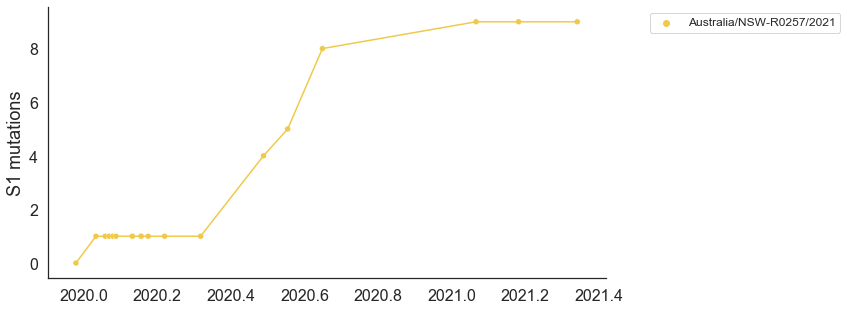

In [208]:
lineage_colors = {"A.23.1": "#475DE9", "B.1.1.7": "#5092E5", "B.1.351": "#64B6C4", 
                  "B.1.427+B.1.429":"#80CC9A", "B.1.525":"#A3D572", "B.1.526":"#CCD656", 
                  "B.1.617":"#EFCA49", "C.37":"#FFAB3F", "P.1":"#FF7235", "P.3":"#F82D2A", 'unassigned':"#ABABAB"}


        
# to make this more legible, only look at a couple paths
# pick node from each emerging clade

# nodes_to_plot = {
#     'DRC/214214/2021':"A.23.1", 
#     'USA/GU-CDC-2-4242992/2021':"B.1.1.7", 
#     'Philippines/58693/2021':"B.1.351", 
#     'Mexico/CAM-InDRE_FB14297_S1826/2021':"B.1.427+B.1.429", 
#     'Niger/IPP10318/2021':"B.1.525", 
#     'USA/WV-WVU-WV119426/2021':"B.1.526", 
#     'Jordan/Biolab017/2021':"B.1.617", 
#     'Mexico/YUC-InDRE_FB13187_S1693/2021':"C.37", 
#     'Argentina/INEI104173/2021':"P.1", 
#     'NewZealand/21MV0168/2021':"P.3", 
#     'Australia/QLD1825/2021':"unassigned"}


# even fewer, to make lines easier to see
nodes_to_plot = {
#     'Kenya/C85262/2021':"A.23.1", 
#     'USA/GU-CDC-2-4242992/2021':"B.1.1.7", 
#     'Philippines/58693/2021':"B.1.351", 
#     'Tunisia/29100/2021': "B.1.351",
    'Australia/NSW-R0257/2021': "B.1.617",
#     'Argentina/INEI104173/2021':"P.1"
}

cmap = {k:lineage_colors[v] for k,v in nodes_to_plot.items()}

df_subset = df[df['isolate'].isin(nodes_to_plot.keys())]


fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=df_subset, x='date', y='num_s1_mutations', 
             hue='isolate', palette=cmap, ax=ax, legend=False)
sns.scatterplot(data=df_subset, x='date', y='num_s1_mutations', 
                hue='isolate', palette=cmap, ax=ax, legend=True)

ax.set_ylabel('S1 mutations', fontsize = 18)
ax.set_xlabel('', fontsize = 18)
sns.despine(left=False, bottom=False)

plt.yticks(fontsize= 16)
plt.xticks(fontsize= 16)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.25, 1.0), fontsize=12)


Assign each node a number of S1 mutations and RdRp that occurred at this node (rather than the accumulation)

In [218]:
for node in tree.find_clades():
    node.s1_muts_at_node = 0
    node.rdrp_muts_at_node = 0
    
    if hasattr(node, 'branch_attrs'):
        s1_muts_at_this_node = 0
        rdrp_muts_at_this_node = 0
        if 'S' in node.branch_attrs["mutations"]:
            for mut in node.branch_attrs["mutations"]['S']:
                mut_pos = int(mut[1:-1])
                if mut_pos in range(14,686):
                    s1_muts_at_this_node+=1
                
            
            
        elif "ORF1a" in node.branch_attrs["mutations"]:
            for mut in node.branch_attrs["mutations"]["ORF1a"]:
                if int(mut[1:-1]) in range(4492,4401):
                    rdrp_muts_at_this_node+=1

        elif "ORF1b" in node.branch_attrs["mutations"]:
            for mut in node.branch_attrs["mutations"]["ORF1b"]:
                if int(mut[1:-1]) in range(1,923):
                    rdrp_muts_at_this_node+=1


        node.s1_muts_at_node = s1_muts_at_this_node         
        node.rdrp_muts_at_node = rdrp_muts_at_this_node 
    

In [219]:
all_s1_counts = []

for node in tree.find_clades():
    all_s1_counts.append(node.s1_muts_at_node)
    
mean_s1_counts = sum(all_s1_counts)/len(all_s1_counts)

deviations = [(x - mean_s1_counts) ** 2 for x in all_s1_counts]
# Variance
variance_s1_counts = sum(deviations) / len(all_s1_counts)

index_of_dispersion = variance_s1_counts/mean_s1_counts

print(index_of_dispersion)

2.512331689167327


In [220]:
all_rdrp_counts = []

for node in tree.find_clades():
    all_rdrp_counts.append(node.rdrp_muts_at_node)
    
mean_rdrp_counts = sum(all_rdrp_counts)/len(all_rdrp_counts)

deviations_rdrp = [(x - mean_rdrp_counts) ** 2 for x in all_rdrp_counts]
# Variance
variance_rdrp_counts = sum(deviations_rdrp) / len(all_rdrp_counts)

index_of_dispersion_rdrp = variance_rdrp_counts/mean_rdrp_counts

print(index_of_dispersion_rdrp)

1.0733085388221018
